*Copyright (C) 2021 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Quadratic Unconstrained Binary Optimization (QUBO) with Lava

This tutorial ramps up users who want to use Lava's solver for quadratic unconstraint binary optimization (QUBO) problems. It starts with an intuitive description of the algorithm behind the solver, before it explains how to generally encode and solve arbitrary QUBO workloads on CPU and Loihi2. As example application, we will apply the solver to search for the the maximum independent set of a graph. An outlook will finally give a glimpse into the future features of the Lava solver that will be enabled in later software releases. 

In a future release, this tutorial will also provide guidance to benchmark between Loihi1, Loihi2, and
CPU-based state-of-the-art solvers. Benchmarking metrics will include the solution accuracy, run
time, and energy consumption.

## Recommended tutorials before starting

- [Installing Lava](./tutorial01_installing_lava.ipynb "Tutorial on Installing Lava")

## Required Python modules

To solve QUBOs on Loihi2, we import the corresponding modules from Lava.

In [1]:
# Interface for QUBO problems
from lava.lib.optimization.problems.problems import QUBO
# Generic optimization solver
from lava.lib.optimization.solvers.generic.solver import OptimizationSolver, solve

In addition, we import auxiliary modules to generate the workloads and run the solver.

In [2]:
import os
import numpy as np

## An intuitive description of Lava's QUBO solver

In previous work, we found that our first generation Loihi 1 chip can solve QUBOs more than 17x faster and more than 670x more energie efficient than the CPU-based solver QBSolv. This solver was developed by DWave Systems and, according to their benchmarking, "executes in two-thirds of the time of the best previously known implementation" [1].

Our Lava solver translates this solver to Loihi 2 to exploit this chip's higher speed, efficiency, and new hardware features designed for optimization.

#### The QUBO formalism

A quadratic unconstrained binary optimization (QUBO) task is an NP-hard combinatorial optimization problem with a range of industrial applications. Its goal is to minimize the cost function

&emsp;&emsp; $\underset{x}{\text{min}}\; \mathbf{x}^T \mathbf{Q} \mathbf{x} $ ,

which is subject to no constraints. This equation is defined by the QUBO matrix $\mathbf{Q}\in\mathbb{R}^{n\times n}$ and the vector of binary variables, $\mathbf{x} \in \{0,1\}^n$ .

#### Lava's QUBO solver

To solve QUBOs, Lava currently implements a spiking version of a Boltzmann machine that was inspired by the work of Jonke et al. [2]. A detailed algorithmic description of the solver will be published soon.

To give a rough intuition of the solver, it represents binary variables as neurons that either spike (variable value=1) or are silent (value=0).

<br>

<div>
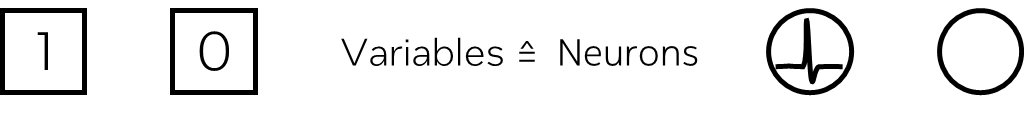
</div>

Each neuron has an internal state representing the probability that the neuron should spike. When the state exceeds a threshold, the neuron spikes and the variable is thus switched to 1. Once a spike occurs at neuron $i$, the synapses forward the spikes according to the off-diagonal QUBO weights $Q_{ij}$ to other neurons $j$. Negative weights increase the chance that the connected neuron will spike, positive weights decrease the chance. <br>
On-diagonal weights $Q_{ii}$ add a bias to the neurons state variable, which continuously increases the chance that the neuron will spike.

<br>

<div>
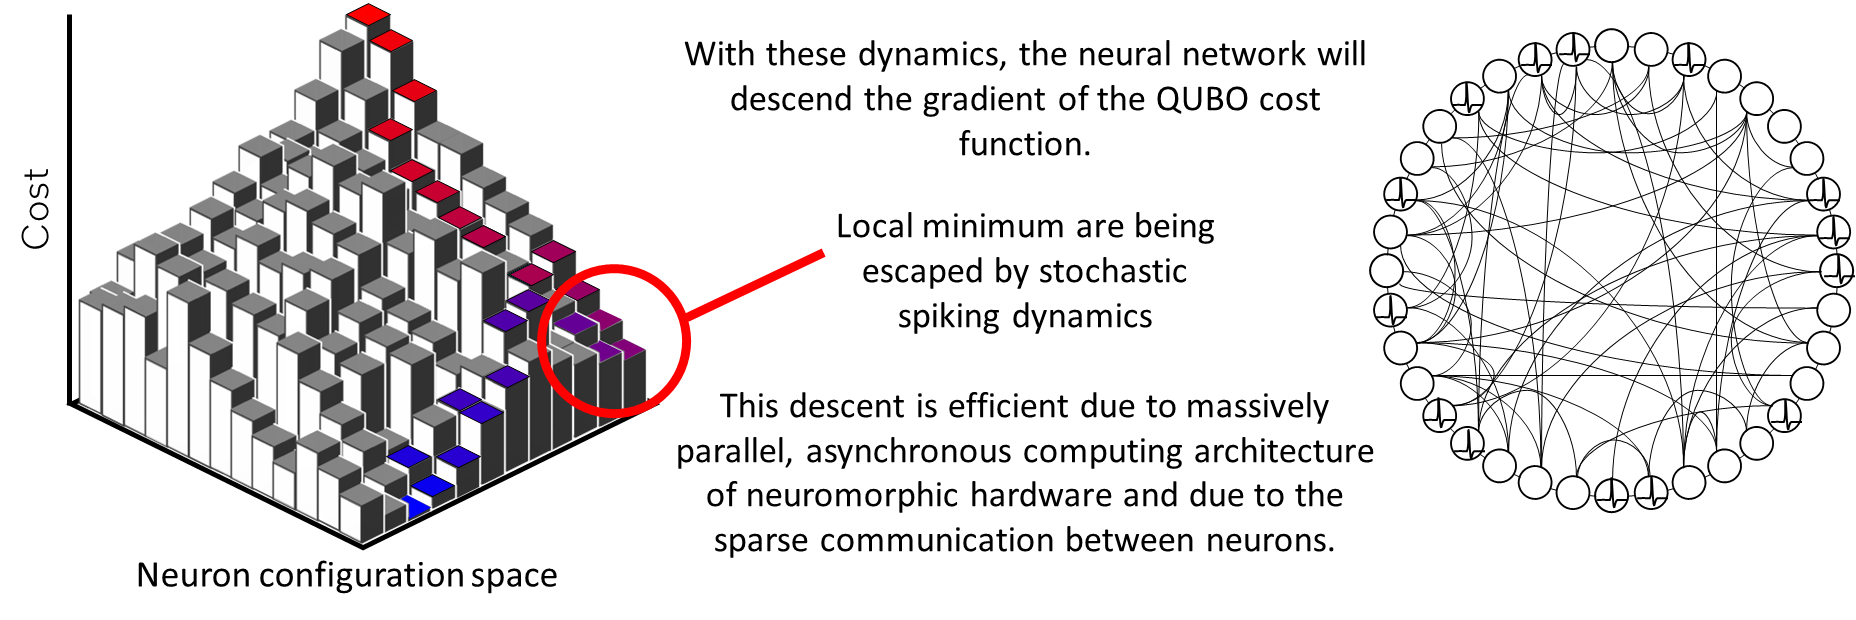
</div>

## A quick start to solving QUBOs on Loihi 2

Solving the QUBO in Lava involves three steps:
<ol>
<li>Define the QUBO workload.</li>
<li>Provide a set of hyperparameters.</li>
<li>Call the Lava solver.</li>
</ol>

The following code will solve the toy QUBO defined by

&emsp;&emsp; $\underset{x}{\text{min}}\; \mathbf{x}^T 
\begin{pmatrix}
-5& 2 & 4 & 0 \\
 2& -3& 1 & 0 \\
 4& 1 & -8& 5 \\
 0& 0 & 5 & -6
\end{pmatrix}
\mathbf{x} $ .

#### Define a QUBO workload

Lava provides an easy interface to encode QUBO problems, by providing the QUBO matrix. Once encoded, the problem is provided to Lava's _OptimizationSolver_, a generic solver for constraint optimization problems.

In [3]:
# Define the QUBO matrix
q = np.asarray([[-5, 2, 4, 0],
                [2, -3, 1, 0],
                [4, 1, -8, 5],
                [0, 0, 5, -6]])

# Instantiate the QUBO problem
qubo_problem = QUBO(q=q)

# Instantiate a constraint optimization solver for this workload
solver = OptimizationSolver(qubo_problem)

#### Provide a set of hyperparameters


The solution quality and run time of Lava's solver depends on a good choice of hyperparameters. This choice depends on the specific type of problem. While the hyperparameter tuning is currently a manual task, future releases will provide utilities for its automation.

Lava's optimization solver supports four hyperparameters:

| Hyperparameter | Data type | Allowed range | Meaning | 
| :- | :- | :- | :-|
| var_comm_rate | int | $[1, 2^{24}]$ | Number of time steps it requires a neuron to fire in the absence of noise.
| noise_amplitude | int | $[0, 2^{24}-1]$ | Multiplicative factor to upscale the stochastic noise in the network.
| step_size | int | $[1, 2^{24}]$ | Value added in each time step to the state variable.
| init_value | Array[binary] | {0, 1} | Vector providing an initial guess for the solution.

The hyperparamaters are provided to the solver as dictionary.

In [4]:
hyperparameters = {
    "steps_to_fire": 8,
    "noise_amplitude": 4,
    "step_size": 1,
    "init_value": np.zeros(4, )
}

#### Solve the QUBO on a CPU

A call to the _solve_ method of Lava's optimization solver then tackles the provided workload. Note that the call defines a CPU as backend to run the solver.

When running on a CPU backend, Lava's solver mimics the algorithm developed for Loihi 2 at default. In future releases, Lava will also allow to run external state-of-the-art CPU-based algorithms for comparison.

As stopping condition, you can provide the solver with a maximum number of time steps (_timeout_) and/or a target cost. In many cases, the user will not know the target cost and thus choose a maximum number of time steps. Providing a target cost is more useful if the user knows a cost that would be acceptable for the specific application. These two options will be extended in the future by more advanced stopping criteria, such as convergence.

Lava will print an obtained solution whenever it found a local minimum. Then it continues its search until either stopping condition is fullfilled.

In [5]:
# Solve the QUBO using Lava's OptimizationSolver on CPU
solution = solver.solve(timeout=10000,
                        target_cost=-11.0,
                        hyperparameters=hyperparameters,
                        backend='CPU')

# Calculate the cost of the obtained solution
cost = solution.T @ q @ solution

print(f'\nSolution of the provided QUBO: {solution}\n'
      f'QUBO cost of solution: {cost} (Lava on Loihi2) vs {-11.0} (optimal)\n')

Found a solution with cost: -3
Read solution: [0 1 0 0]
with cost: -3
Found a solution with cost: -4
Read solution: [1 1 0 0]
with cost: -4
Found a solution with cost: -5
Found a solution with cost: -6
Read solution: [0 0 0 1]
with cost: -6
Found a solution with cost: -8
Read solution: [0 0 1 0]
with cost: -8
Found a solution with cost: -9
Read solution: [0 1 0 1]
with cost: -9
Found a solution with cost: -11
Read solution: [1 0 0 1]
with cost: -11
Best cost found: -11
Best cost found: -11
pausing simulation

Solution of the provided QUBO: [1. 0. 0. 1.]
QUBO cost of solution: -11.0 (Lava on Loihi2) vs -11.0 (optimal)



#### Solve the QUBO on Loihi2

In order to take advantage of the large speed and energy efficiency of Loihi2, the system must enable access to this chip if available.

In [7]:
# Enable SLURM, the workload manager used to distribute Loihi2 resources to users
os.environ['SLURM'] = '1'

# Define the Loihi2 boards used to run the workload
os.environ["LOIHI_GEN"] = "N3B3"
os.environ["PARTITION"] = "kp"

Given this setup, we can run the QUBO solver on Loihi2 by just changing the _backend_ parameter.

While the CPU implementation closely mimics the Loihi2 implementation, the solutions may differ. This is due to slightly different noise models.

Please note that the following cell runs only on systems that have physical access to a Loihi2 chip.

In [10]:
# Instantiate a constraint optimization solver for this workload
solver = OptimizationSolver(qubo_problem)

# Solve the QUBO using Lava's OptimizationSolver on Loihi2
solution = solver.solve(timeout=10000,
                        target_cost=-7,
                        hyperparameters=hyperparameters,
                        backend='CPU')
# ToDo: Change backend back to Loihi2!

# Calculate the cost of the obtained solution
cost = solution.T @ q @ solution

print(f'\nSolution of the provided QUBO: {solution}\n'
      f'QUBO cost of solution: {cost} (Lava on Loihi2) vs {-11.0} (optimal)\n')

AssertionError: 'delays' is not a member of 'Var' collection of process 'Process_22::Dense'

## Maximum Independent Sets as example application

To illustrate how the QUBO solver can solve optimization tasks, this tutorial determines maximum independent sets, an NP-hard task from graph theory. The goal of this task is to find the largest subset of vertices in a graph that are mutually unconnected. In the following graph, the purple nodes form such a set:

<br>

<div>
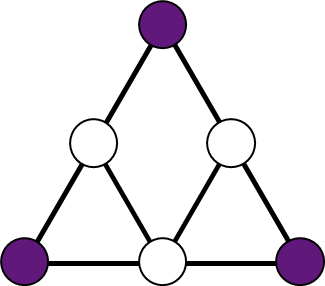
</div>

#### The QUBO formulation

As a first step, the MIS problem needs to be translated into a QUBO formulation. Finding the MIS for a graph G=(V, E) with vertices V and edges E can be formulated as a QUBO problem, where we need to optimize the problem

&emsp;&emsp; $\underset{x}{\text{min}}\; \mathbf{x}^T \mathbf{Q} \mathbf{x} $ ,

where the variables denote

&emsp;&emsp; $x_i = \begin{cases}
    1,& \text{if } \text{vertex i in MIS} \\
    0,& \text{else}
\end{cases}$ .

The off-diagonal elements of the QUBO matrix are equivalent to each other, and the same applies to on-diagonal elements,

&emsp;&emsp; $Q_{ij} = \begin{cases}
    w_{diag},& \text{if } \text{i = j} \\
    w_{off},& \text{else}
\end{cases}$ .

Thus, the problem can be expressed as

&emsp;&emsp; $\underset{x}{\text{min}} \;\; w_{off} \underset{(i,j) \in E}{\sum} x_i x_j - w_{diag} \underset{i \in V}{\sum} x_i$ .

The solution to this problem is equivalent to the MIS if the off-diagonal weights $w_{off}$ and on-diagonal entries $w_{diag}$ fulfill 

&emsp;&emsp; $w_{off} > 2 \cdot w_{diag}$ .

#### Utility functions

To create and analyze MIS workloads, we define utility functions in order to
<ol>
<li>create random graphs.</li>
<li>translate the MIS task into its QUBO formulation.</li>
<li>analyze the solution of a given solution to the QUBO problem.</li>
</ol>

In [ ]:
class MISUtils():
    
    @staticmethod
    def get_random_graph(n_vert, p_edge, seed=6659):
        """Creates an undirected graph with random connectivity between nodes.
        
        Parameters
        ----------
        n_vert : int
            Number of vertices in the graph
        p_edge: float
            Random probability [0, 1] that two vertices are connected
        seed: int
            Seed for random number calculator
            
        Returns
        -------
        adj : Array[binary]
            Adjacency matrix
        """

        np.random.seed(seed)

        # generate a random binary matrix of size n_vert x n_vert
        adj = (np.random.rand(n_vert,n_vert) < p_edge).astype(int)

        # delete diagonal elements as nodes have no self-connectivity
        adj = np.triu(adj)
        # ensure that the matrix is symmetric
        adj += adj.T - 2*np.diag(adj.diagonal())

        return adj
    
    @staticmethod
    def translate_adj_to_mis_qubo(adj, w_diag, w_off):
        """Creates a QUBO describing the maximum independent set problem
        based on the adjacency matrix of a graph.
        The goal of the QUBO is to minimize the term
            min x^T * Q * x ,
        where the vector 
            x_i = 1 if vertex i is part of the MIs
            x_i = 0 if vertex i is not part of the MIS,
        and the QUBO matrix is given by
            Q_ii = w_diag
            Q_ij = w_off (for i~=j) .
        
        Parameters
        ----------
        adj : Array[binary]
            Adjacency matrix
        w_diag: float
            Weights of diagonal elements of Q.
        w_off: int
            Weights of off-diagonal elements of Q
            
        Returns
        -------
        Q : Array[float, float]
            2D QUBO matrix.
        """
        
        if w_off <= 2 * w_diag:
            raise ValueError("Off-diagonal weights must be > 2 x diagonal weights.")
    
        # Translate the connectivity matrix to a QUBO matrix
        Q = - w_diag * np.eye(adj.shape[0])  + w_off/2 * adj

        return Q

    @staticmethod
    def get_total_cost(x_solution, q):
        """Based on a given solution, returns the value of the cost function.
        
        Parameters
        ----------
        x_solution : Array[binary]
            Vector of length equal to the number of vertices in the graph.
            The ith entry of the vector determines if the ith vertex is a
            member of the MIS.
        q: Array[float, float]
            2D QUBO matrix.
            
        Returns
        -------
        float
            Cost of the given solution.
        """
        
        return (solution.T @ q @ solution)

#### Define and solve the QUBO workload

We now define a random graph with 45 nodes and a propability of 0.5 that two random notes are connected. The task to find the maximum independent set within the graph is then translated into a QUBO formulation and encoded in Lava.

In [ ]:
# Create the connectivity matrix for a random graph
adj = MISUtils.get_random_graph(n_vert=45, p_edge=0.5, seed=7865)

# Translate the connectivity matrix to a QUBO matrix
q = MISUtils.translate_adj_to_mis_qubo(adj, w_diag=1, w_off=4)

# Instantiate the QUBO problem
qubo_problem = QUBO(q=q)

# Instantiate a constraint optimization solver for this workload
solver = OptimizationSolver(qubo_problem)

A call to the _solve_ method of Lava's optimization solver then solves the provided workload on CPU.

In [ ]:
# Define hyperparameters for the solver
hyperparameters = {
    "steps_to_fire": 8,
    "noise_amplitude": 4,
    "step_size": 1,
}

# Solve the QUBO using Lava's OptimizationSolver on CPU
solution = solver.solve(timeout=10000,
                        target_cost=-7,
                        hyperparameters=hyperparameters,
                        backend='CPU')

# Calculate the cost of the obtained solution
cost = MISUtils.get_total_cost(x_solution=solution, q=q)

print(f'\nNodes in maximum independent set (index starts at 0): {np.where(solution)[0]}\n'
      f'QUBO cost of solution: {cost} (Lava on CPU) vs {-7.0} (optimal)\n')

Given physical access to Loihi2, you can directly transfer the same workload to neuromorphic hardware.

In [ ]:
# Solve the QUBO using Lava's OptimizationSolver on Loihi2
solution = solver.solve(timeout=10000,
                        target_cost=-7,
                        hyperparameters=hyperparameters,
                        backend='CPU')
# ToDo: Change backend back to Loihi2!

# Calculate the cost of the obtained solution
cost = MISUtils.get_total_cost(solution=solution, qubo_matrix=q)

print(f'\nNodes in maximum independent set (index starts at 0): {np.where(solution)[0]}\n'
      f'QUBO cost of solution: {cost} (Lava on Loihi2) vs {-7.0} (optimal)\n')

## Future features 

Please note that the Lava solver is currently an early proof of concept to validate the promises of neuromorphic hardware for optimization.<br>
Future releases are expected to provide the following advancements and many more:
- Improved solver performance, e.g., by stochastic noise levels that progressively decrease. 
- New solver algorithms in Lava, like simulated annealing, that exploit the general-purpose programmable neurons available in Loihi2.
- Higher compilation speed. While neuromorphic hardware is fast at solving optimization problems, the time it takes to write the problem to Loihi will be substantially accelerated in the near term.
- Added compiler support for larger problem sizes.
- Automatic hyperparameter tuning.
- More stopping criteria besides a target cost and solver iterations, such as convergence of the solver.
- Utilities that allow an easy benchmarking between Loihi1, Loihi2, and CPU-based state-of-the-art solvers. <br> Benchmarking metrics will include solution accuracy, speed, and energy efficiency.
- Support for Loihi1.

## How to learn more?

Watch this [space](https://github.com/lava-nc/lava-optimization) to learn about upcoming developments to the QUBO solver and the optimization toolbox in Lava in general. 

If you want to find out more about the implementation of the QP solver, have a look at the [Lava documentation](https://lava-nc.org/ "Lava Documentation") or dive into the [source code](https://github.com/lava-nc/lava-optimization/tree/main/src/lava/lib/optimization/solvers/generic
"Source code of the generic constraint optimization solver").
To receive regular updates on the latest developments and releases of the Lava Software Framework please subscribe to the [INRC newsletter](http://eepurl.com/hJCyhb "INRC Newsletter").


## References

[1] D-Wave Systems Inc: Booth, Reinhardt, Roy, _Partitioning Optimization Problems for Hybrid Classical/Quantum Execution_. [Technical report](https://docs.ocean.dwavesys.com/projects/qbsolv/en/latest/_downloads/bd15a2d8f32e587e9e5997ce9d5512cc/qbsolv_techReport.pdf "DWave's technical report"), 2017. <br>
[2] Jonke, Z., Habenschuss, S., and Maass, W. (2016). _Solving constraint satisfaction problems with networks of spiking neurons_. Front. Neurosci. 10:118. doi: 10.3389/fnins.2016.00118